#Important Libraries to be included



In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.utils.data import random_split
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset Preparation

In [ ]:
# Download training dataset
dataset = MNIST(root='data/', download=True)
test_dataset = MNIST(root='data/', train=False)

# MNIST dataset (images and labels) transform to Tensor
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

#Split dataset into training and validation
train_ds, val_ds = random_split(dataset, [50000, 10000])

#Load data in batches
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)


# Model

In [ ]:
input_size = 28*28          # no of inputs
num_classes = 10            # no of outputs

#Linear Regression model
model = nn.Linear(input_size, num_classes)

#Building Own Custom model
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size,num_classes)

  def forward(self,xb):
    xb = xb.reshape(-1,784)
    out = self.linear(xb)
    return out

  def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
  def validation_step(self, batch):
      images, labels = batch 
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss, 'val_acc': acc}
      
  def validation_epoch_end(self, outputs):
      batch_losses = [x['val_loss'] for x in outputs]
      epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
      batch_accs = [x['val_acc'] for x in outputs]
      epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
      return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
      print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

#Accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#Training


In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history


def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)




In [ ]:
history = fit(20, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9432, val_acc: 0.6171
Epoch [1], val_loss: 1.6743, val_acc: 0.7421
Epoch [2], val_loss: 1.4730, val_acc: 0.7785
Epoch [3], val_loss: 1.3209, val_acc: 0.7949
Epoch [4], val_loss: 1.2037, val_acc: 0.8066
Epoch [5], val_loss: 1.1117, val_acc: 0.8157
Epoch [6], val_loss: 1.0378, val_acc: 0.8200
Epoch [7], val_loss: 0.9773, val_acc: 0.8265
Epoch [8], val_loss: 0.9270, val_acc: 0.8299
Epoch [9], val_loss: 0.8844, val_acc: 0.8323
Epoch [10], val_loss: 0.8479, val_acc: 0.8357
Epoch [11], val_loss: 0.8163, val_acc: 0.8399
Epoch [12], val_loss: 0.7887, val_acc: 0.8437
Epoch [13], val_loss: 0.7642, val_acc: 0.8455
Epoch [14], val_loss: 0.7424, val_acc: 0.8472
Epoch [15], val_loss: 0.7229, val_acc: 0.8495
Epoch [16], val_loss: 0.7052, val_acc: 0.8503
Epoch [17], val_loss: 0.6892, val_acc: 0.8511
Epoch [18], val_loss: 0.6746, val_acc: 0.8528
Epoch [19], val_loss: 0.6612, val_acc: 0.8546


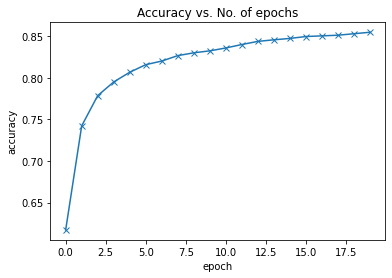

In [ ]:
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Prediction with individual images

Shape: torch.Size([1, 28, 28])
Label: 1


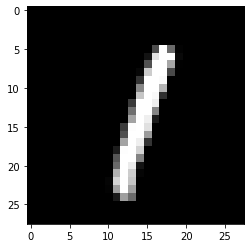

In [ ]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

img, label = test_dataset[5]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()


Label : 4 , Prediction :  4


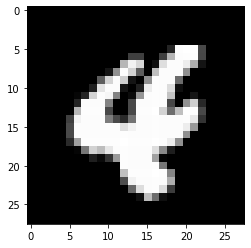

In [ ]:
img, label = test_dataset[95]
plt.imshow(img[0], cmap='gray')
print('Label :',label,', Prediction : ',predict_image(img, model))